# Vizualization - Receiver Operating Characteristic (ROC) curve

In this tutorial, we'll dig into the concept of ROC curves and how to generate interactive ROC plots for more careful interrogation of classifiers.

A receiver operating characteristic curve (ROC) curve illustrates the performance of a binary classifier system in terms of true and false positives detected at certain threshold values for your classifier. 

Broadly, the ROC curve demonstrates *how separable* your two populations are, and how well these populations can be separated by the decision boundaries defined by a machine learning algorithm. It's *not* a metric of value for the model (which we'll discuss later) but it's very helpful for understanding how the model behaves and compares to other approaches (including a plain old coin flip!).

To create a ROC curve, we plot the true positive rate (TPR) and false positive rate (FPR) as functions of a classifier parameter, such as discrimination threshold. The TPR defines how many correct positive results occur among all positive samples available during the test. FPR, on the other hand, defines how many incorrect positive results occur among all negative samples available during the test.

If the probability distributions for both recall and fall-out are known, the ROC curve can be generated by plotting the cumulative distribution function (area under the probability distribution):

![plot](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/ROC_curves.svg/709px-ROC_curves.svg.png "Probability Distribution, courtesy Wikipedia")

Source: Wikimedia

## Case Study

Before we get into the code, let's talk a bit more about why ROC curves and understanding the TPR and FPR are important. 

We'll use this old statistics textbook chestnut: suppose you have developed a diagnostic test that has **99.5% accuracy** for your disease of interest. 

That's an accuracy worth publishing! However, let's take a step back and look at prevalence for that disease. Say the test is for a disease with a prevalence of **1 in 10,000** (you have a 0.01% chance of having it). 

You decide to run the test on all the residents of New York City, because why the hell not. If you run the test on all residents of NYC, that's **8.5 million** people. Since NYC has a population of 8.5M, we can estimate that **850 people should have the disease and you should positively identify about 846 of them** with a single test: (8.5M people)\*(1/10,000 disease/normal)\*(0.995) = 846 diseased people. 

As a warning, since your test is bit inaccurate, you should expect some false negatives (Type II error).

--- 

OK so let's look at the math and see how many patients we test as "positive." 


In [1]:
from accstats import confusion_matrix

_ = confusion_matrix(acc=0.995, subpop=1e-4, population=8.5e6)


Inputs
------------
Accuracy (%): 99.5
Subpopulation (%): 0.01
Population size: 8500000
Predicted subpopulation size: 850

Results
------------
True Positives (Power): 846
False Positives (Type I): 42500
True Negatives: 8456654
False Negatives (Type II): 4

Derivations
------------
True Positive Rate (Recall): 0.9953
False Positive Rate: 0.005
Precision: 0.0195
Specificity: 0.995
False Discovery Rate: 0.9805
F-Score: 0.0383


Hold on a minute ... your results came back and you actually detected **43,346** people with the disease (846 true + 42500 false positives)...

What happened? 

Well, that 99.5% accuracy means there's 0.5% *inaccuracy*. And since your two classes (diseased vs. normal) are dramatically imbalanced, that means you are likely to accumulate a ton of false positives (Type I error).

Though the True Positive Rate and Specificity look good, the high Type I error led to very low Precision and high False Discovery Rate. Essentially, a lot of healthy people are going to think they're sick if they only use your test as an indicator.

This case study is just to illustrate that **accuracy is not necessarily the best metric to use when deciding on a classifier**. Instead, it's better to understand the trade-off between precision and recall or your true and false positive rates. And in the case of medical diagnostics, context matters and gives a fuller picture of whether you should receive a specific diagnosis (like do you exhibit symptoms and how intensely? This is why doctors are useful :)! )  

--- 

Onto the code for ROC curves! We'll again be using matplotlib for static plots and Bokeh for dynamic plots, which I've come to really enjoy as a prototyping tool.

### Load libraries

In [2]:
# basic packages
import pandas as pd
import numpy as np
from itertools import cycle

# sklearn
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
cnames = dict((k, v) for k, v in cnames.items() if 'dark' in k) # get only dark colors
%matplotlib inline

### Import data and run 2D PCA

We'll use the [UCI breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) which is bundled with scikit-learn as a toy dataset.

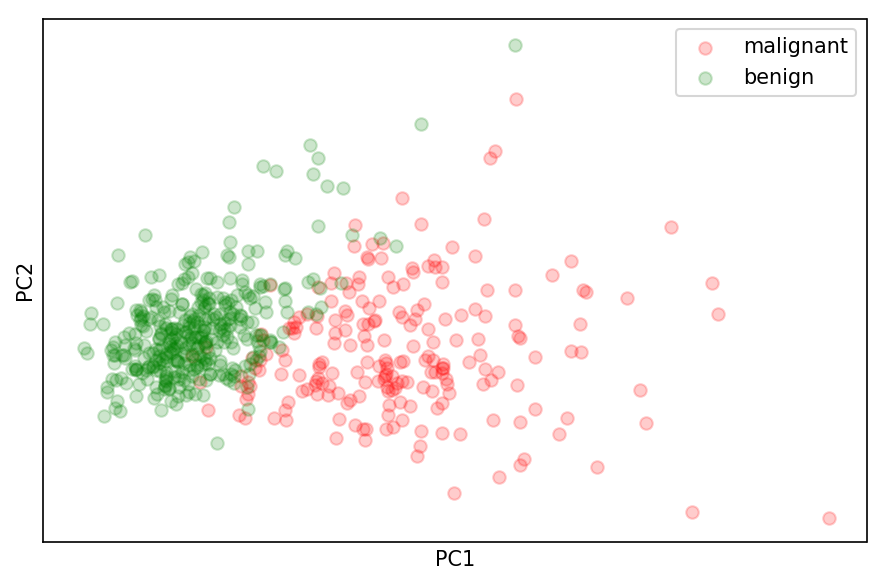

In [3]:
# Load data
data = datasets.load_breast_cancer()
X = data.data
y = data.target
target_names = list(data.target_names)


def PCA_2D_labeled(X, y, cnames:list, target_names:list):
    """
    Get a quick 2D rescaled PCA of a labeled dataset
    
    Args:
        X (numpy.ndarray): data
        y (numpy.ndarray): labels
        cnames: a list of color names (str)
        target_names: a list of target names (str)
        
    Returns:
        matplotlib plot object
    """

    # rescaled, 2D PCA
    X_2D = PCA(2).fit_transform(StandardScaler().fit_transform(X))

    # plot
    plt.figure(dpi=150)
    for c, i, t in zip(['red', 'green'], set(y), target_names):
        # plot each column with a color pertaining to the labels
        plt.scatter(X_2D[y==i, 0], X_2D[y==i, 1], color=c, alpha=.2, lw=1, label=t)
    plt.legend(loc='best')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()
    return plt


# let's do a quick viz with PCA to get a sense of the data
_ = PCA_2D_labeled(X, y, cnames, target_names)

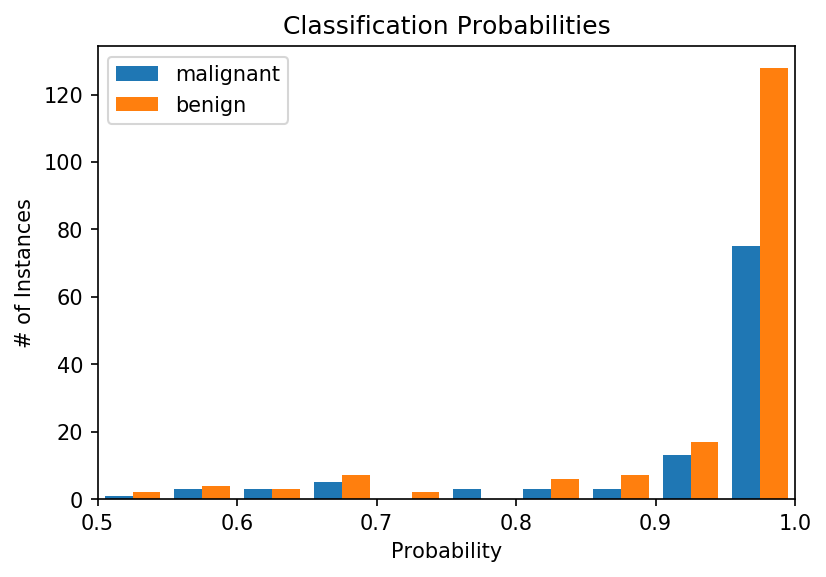

In [4]:
""" Let's look at a basic Random Forest applied to the data """

# train test split the data (X, y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# train
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

# get the probability distribution
probas = rf_clf.predict_proba(X_test)

# plot
plt.figure(dpi=150)
plt.hist(probas, bins=20)
plt.title('Classification Probabilities')
plt.xlabel('Probability')
plt.ylabel('# of Instances')
plt.xlim([0.5, 1.0])
plt.legend(target_names)
plt.show()

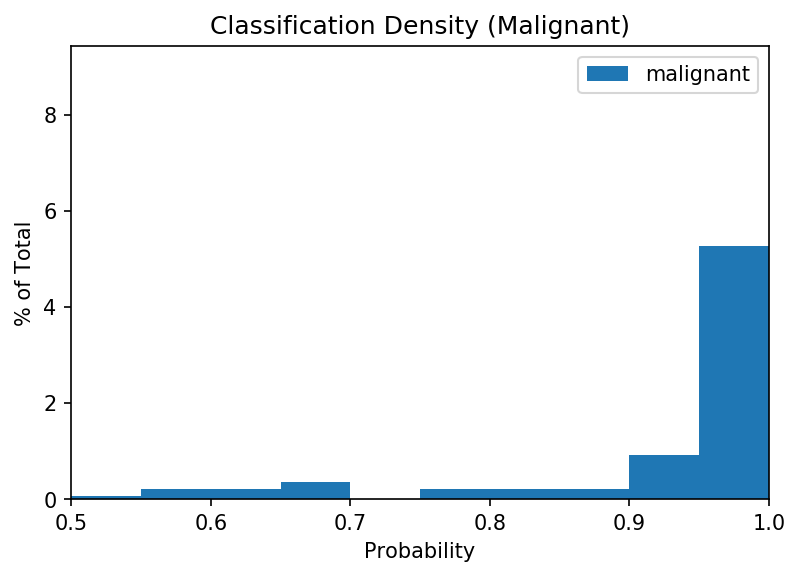

In [5]:
# plot with density instead of counts
plt.figure(dpi=150)
plt.hist(probas[:,0], density=True, bins=20)
plt.title('Classification Density (Malignant)')
plt.xlabel('Probability')
plt.ylabel('% of Total')
plt.xlim([0.5, 1.0])
plt.legend(target_names)
plt.show()

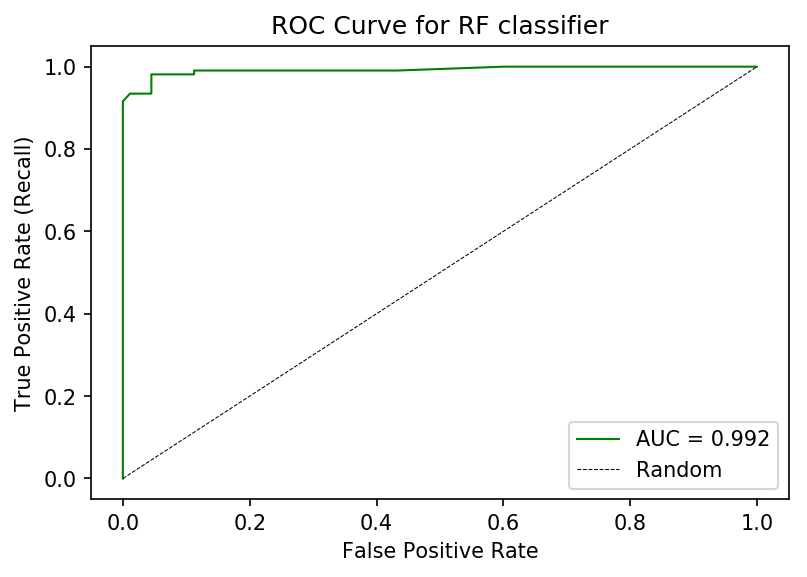

In [6]:
""" Straightforward ROC curve """

# get false and true positive rates
fpr, tpr, _ = roc_curve(y_test, probas[:,0], pos_label=0)

# get area under the curve
roc_auc = auc(fpr, tpr)

# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

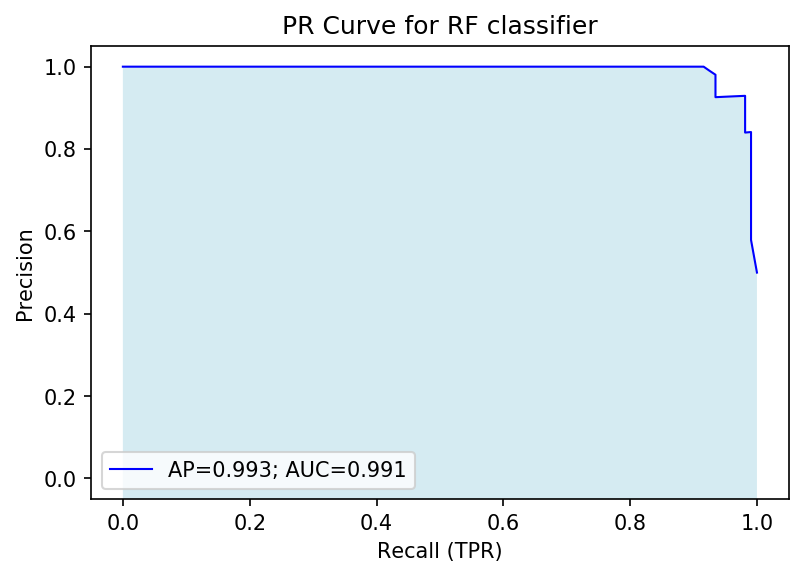

In [7]:
""" Straightforward Precision Recall Curve """

# get precision and recall values
precision, recall, _ = precision_recall_curve(y_test, probas[:,0], pos_label=0)

# average precision score
avg_precision = average_precision_score(y_test, probas[:,1])

# precision auc
pr_auc = auc(recall, precision)

# plot
plt.figure(dpi=150)
plt.plot(recall, precision, lw=1, color='blue', label=f'AP={avg_precision:.3f}; AUC={pr_auc:.3f}')
plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)

plt.title('PR Curve for RF classifier')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

## Let's put it all together

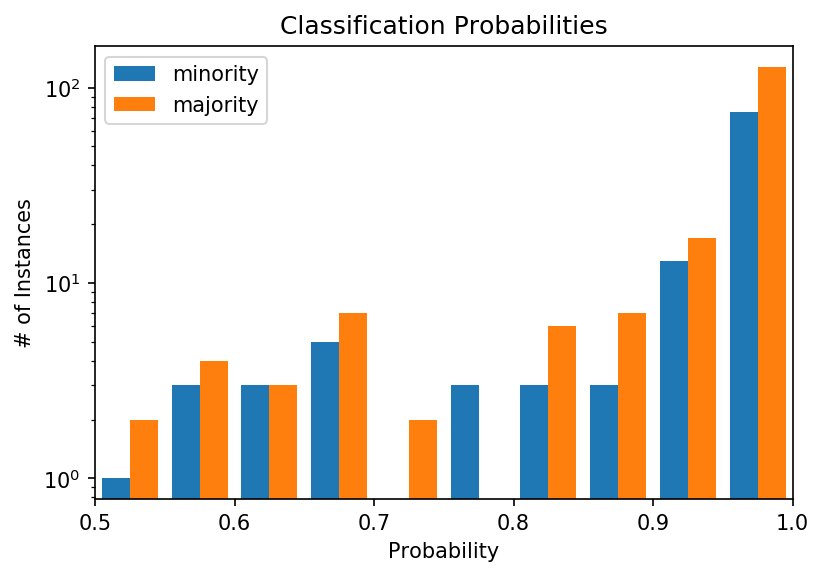

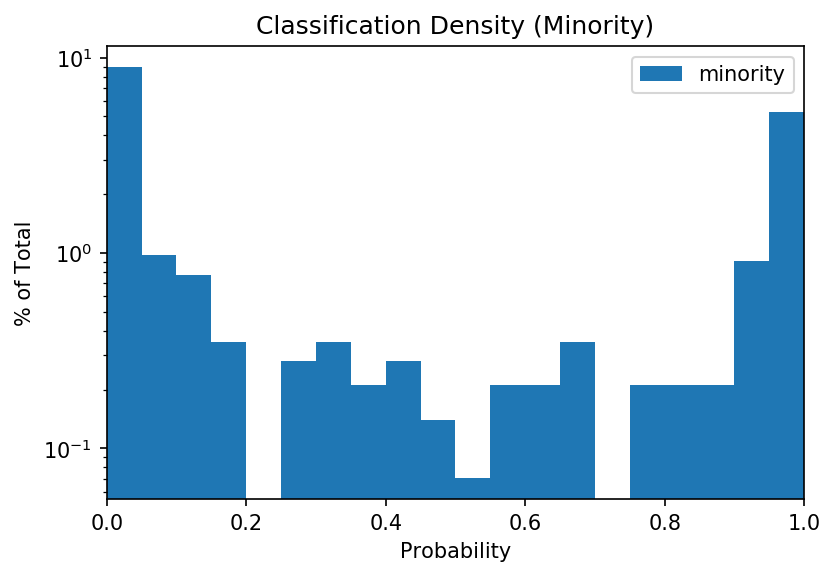

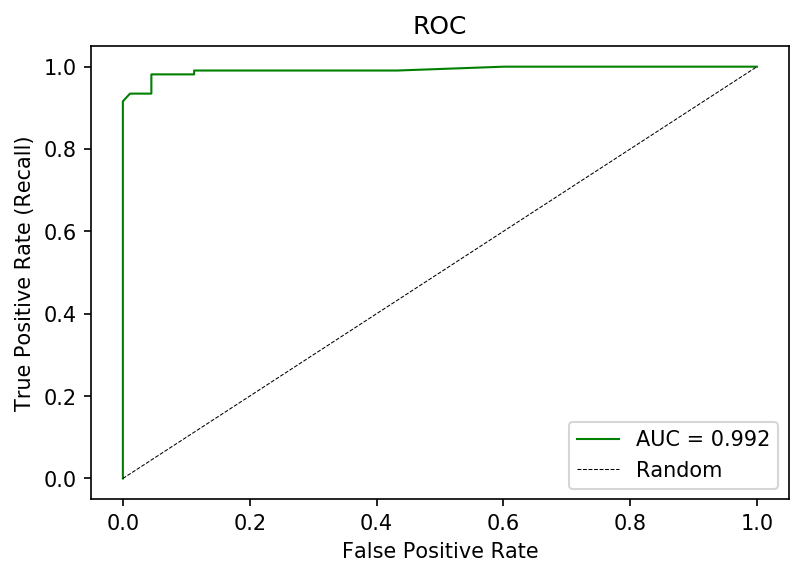

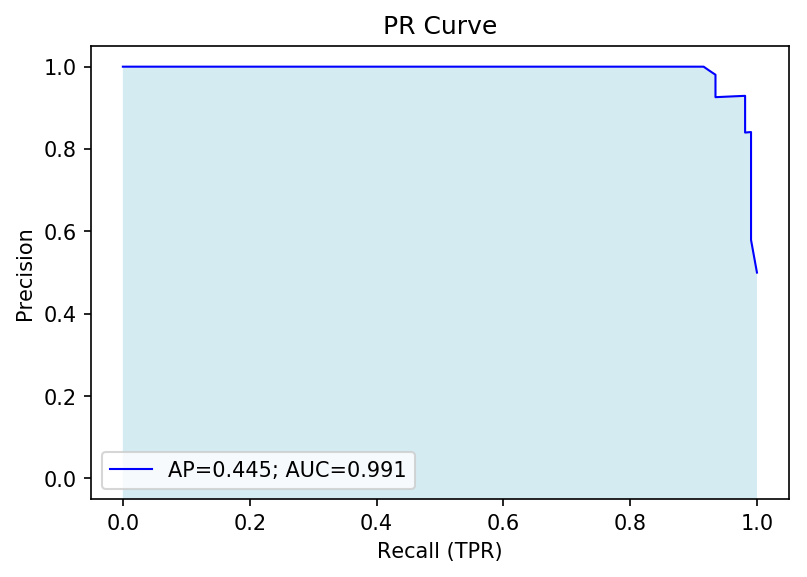

In [8]:
""" Function to return all plots for a classifer """

def classifier_plots(clf_trained, X_test, y_test, target_names:list, minority_idx:int=0, ylog:bool=False):
    """
    Get summary plots for a trained classifier
    
    Args:
        clf_trained: trained sklearn clf
        X_test (np.ndarray): withheld test data
        y_test (np.ndarray): withheld test data labels
        target_names (list): list of target labels/names
        minority_idx: (int): index for the minority class (e.g. 0, 1) 
        ylog (str): toggle log-scaling on yaxis
        
    Returns:
        None
    """
    
    """ Probabilty Dist """
    # get the probability distribution
    probas = clf_trained.predict_proba(X_test)

    # PLOT - count
    plt.figure(dpi=150)
    plt.hist(probas, bins=20)
    plt.title('Classification Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('# of Instances')
    plt.xlim([0.5, 1.0])
    if ylog: plt.yscale('log')
    plt.legend(target_names)
    plt.show()
    
    
    # PLOT - density
    plt.figure(dpi=150)
    plt.hist(probas[:, minority_idx], bins=20, density=True)
    plt.title('Classification Density (Minority)')
    plt.xlabel('Probability')
    plt.ylabel('% of Total')
    if ylog: plt.yscale('log')
    plt.xlim([0, 1.0])
    plt.legend(target_names)
    plt.show()
    
    """ ROC curve """

    # get false and true positive rates
    fpr, tpr, _ = roc_curve(y_test, probas[:,0], pos_label=0)

    # get area under the curve
    clf_auc = auc(fpr, tpr)

    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {clf_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.show()
    
    """ Precision Recall Curve """

    # get precision and recall values
    precision, recall, _ = precision_recall_curve(y_test, probas[:,0], pos_label=0)

    # average precision score
    avg_precision = average_precision_score(y_test, probas[:,0])

    # precision auc
    pr_auc = auc(recall, precision)

    # plot
    plt.figure(dpi=150)
    plt.plot(recall, precision, lw=1, color='blue', label=f'AP={avg_precision:.3f}; AUC={pr_auc:.3f}')
    plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)

    plt.title('PR Curve')
    plt.xlabel('Recall (TPR)')
    plt.ylabel('Precision')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.show()
    

""" get all plots """
classifier_plots(rf_clf, X_test, y_test, ['minority', 'majority'], ylog=True)

## Imbalanced Classes

Majority: 9457; Minority: 543


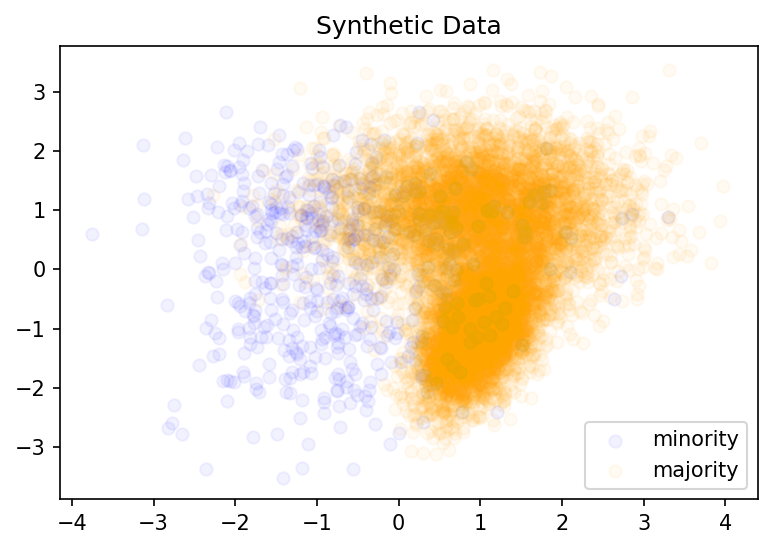

In [9]:
""" Make a synthetic dataset """
from sklearn.datasets import make_classification

# Synthetic data with imbalanced classes
minority_class_prevalence = 0.05
class_balance = [minority_class_prevalence, 1.0-minority_class_prevalence]

# make 2d data
X_2D, y = make_classification(n_classes=2, 
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           n_repeated=0,
                           n_samples=10000,
                           weights=class_balance, 
                           random_state=10)

# print out classes
sum_class_1 = np.sum(y)
sum_class_2 = len(y) - sum_class_1
print(f"Majority: {sum_class_1}; Minority: {sum_class_2}")

# plot
plt.figure(dpi=150)
for c, i, t in zip(['blue', 'orange'], [0, 1], ['minority', 'majority']):
    # plot each column with a color pertaining to the labels
    plt.scatter(X_2D[y==i, 0], X_2D[y==i, 1], color=c, alpha=.05, lw=1, label=t)
plt.legend(loc='best')
plt.title('Synthetic Data')
plt.show()

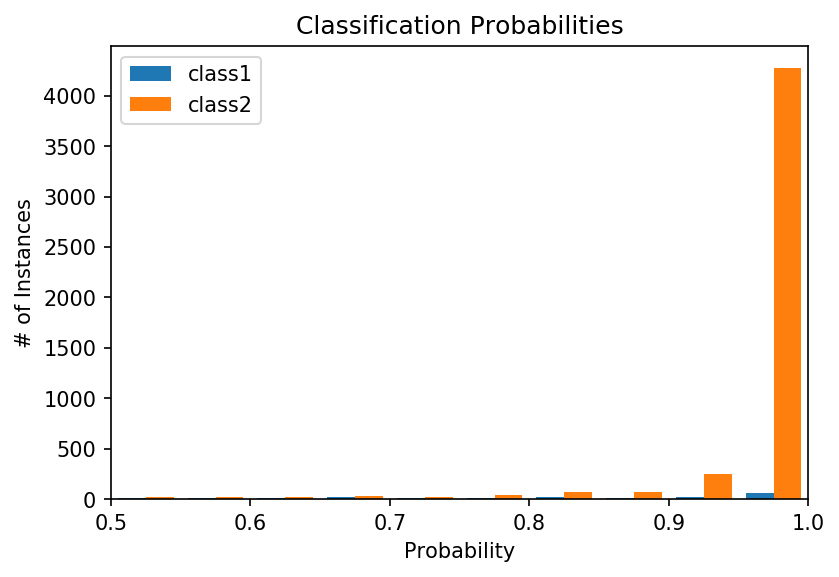

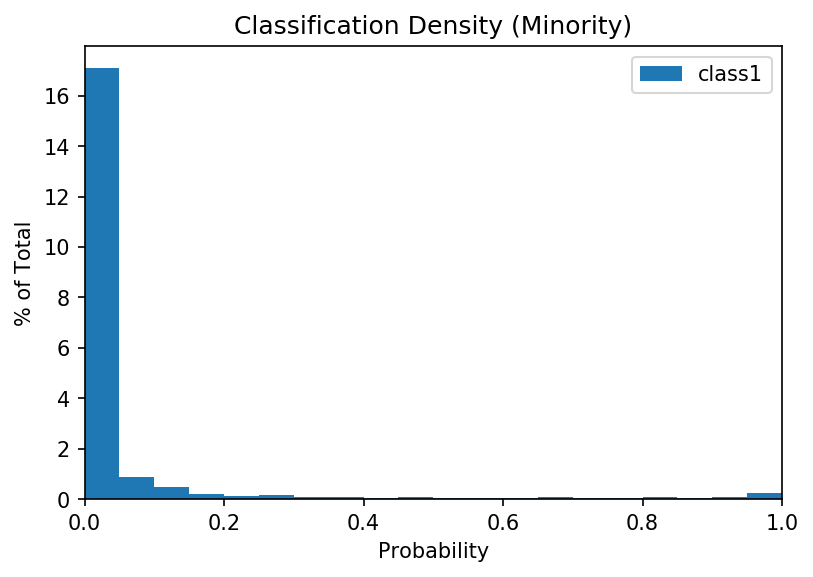

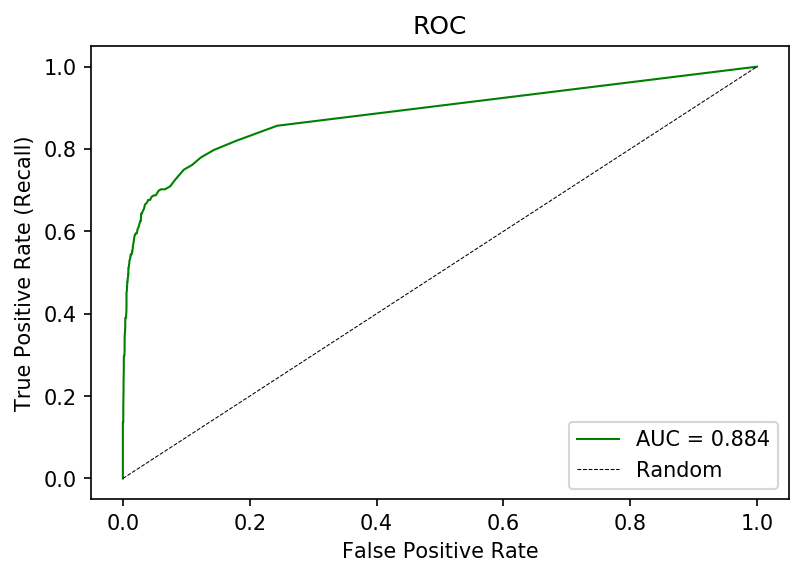

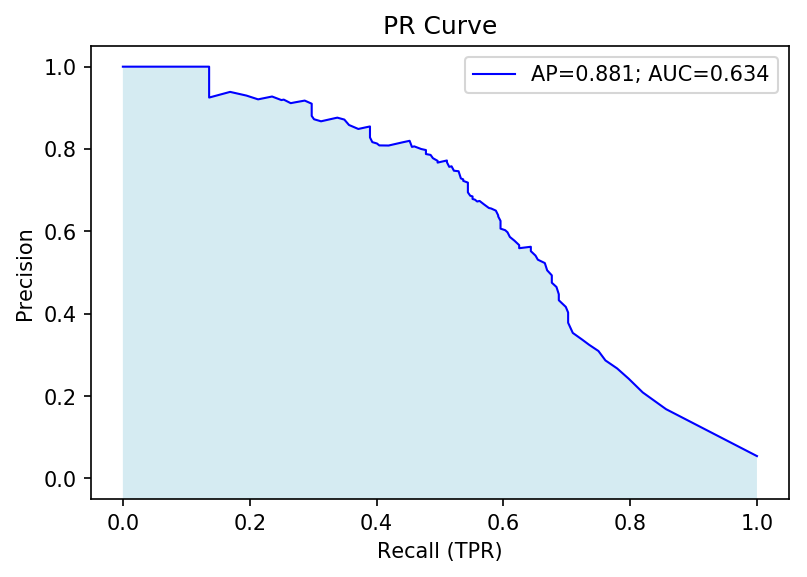

In [10]:
""" split and train """

# split data
X_train, X_test, y_train, y_test = train_test_split(X_2D, y, test_size=0.5)

# train
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

# plots
classifier_plots(rf_clf, X_test, y_test, ['class1', 'class2'])

# Cross Validation

This wasn't covered in the blog post, but here's some code snippets that allows you to cross-validate that data and generate curves for each fold.

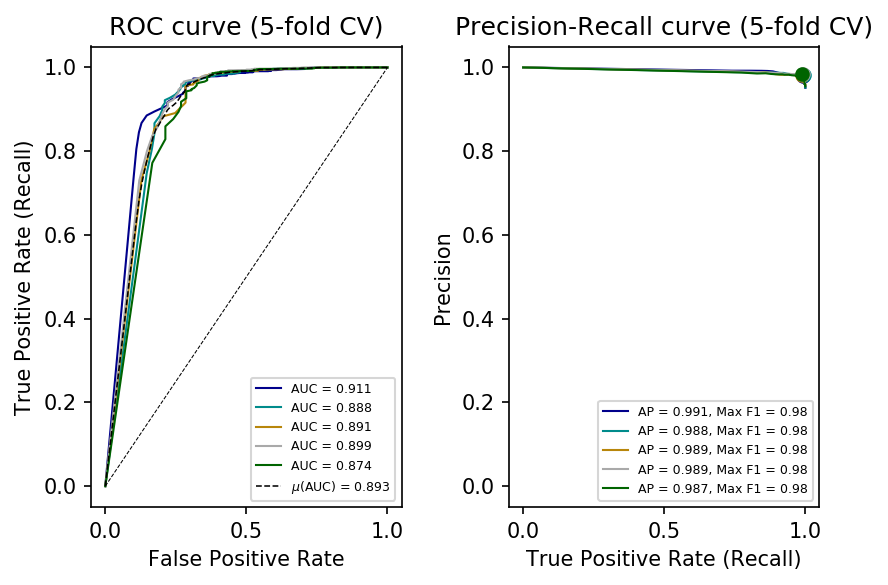

In [11]:
def check_extension(filename:str, ext:str='.png') -> str:
    """
    Verify if a filename ends with a desired extension, coerces if not
    
    Args:
        filename (str): input filename [e.g. 'plot.png']
        ext (str): desired extension [default: '.png']
        
    Returns:
        str: output filename, original if valid ext
        
    """
    # Add '.' to extension if not input
    if not filename.endswith(ext): 
        new_filename = filename + ext
        print(f"Filename changed from '{filename}' to '{new_filename}'")
        return new_filename
    else:
        return filename


def plot_binary_ROC(clf, X, y, scaler=None, cv_fold:int=3, pos_label_:int=None, dpi_:int=150, png_filename:str=None, verbose:bool=False):
    """
    Plot a ROC curve for a binary classifier with n='cv-fold' cross-validations
    
    Args:
        clf:          untrained classifier object (e.g. rf_clf = RandomForestClassifer())
        X:            training + testing data
        y:            targets (numeric/integers)
        scaler:       scaler to rescale data, e.g. StandardScaler() [default: None]
        cv_fold:      cross-validations to run [default: 3]
        dpi_:         dpi resolution for plot (x,y) [default: 150] 
        pos_label_:   if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
        png_filename: if you wish to save to png, give filename [default: None]
    
    Returns:
        clf: trained scikit learn classifer object
    
    LEGEND:
        - AUC: area under ROC curve
        - TPR: true positive rate
        - FPR: false positive rate
        - AP: average precision
        - Max F1: maximum F1 score
    """
    
    """ Setup """
    
    from sklearn.model_selection import train_test_split, StratifiedKFold  # sklearn > v0.18

    # rescale data
    if scaler is not None:
        X = scaler.fit_transform(X)
        if verbose:
            print(f"Data (X) rescaled using {scaler}.")

    # Set up mean true and false positive rates
    # -- mean_tpr begins as 0, and we'll update it as we fit the classifiers
    # -- mean_fpr is our x-axis so we pre-calculate it from 0 to 100 (%)
    mean_tpr, mean_fpr = 0, np.linspace(0, 1, 101) # np.linspace(start, stop, datapoints)
    mean_prec, mean_rec = 0, np.linspace(0, 1, 101) # np.linspace(start, stop, datapoints)

    # Set the cross-validation fold
    if cv_fold > 1:
        skf = StratifiedKFold(cv_fold)
    else:
        print(f"ERROR: cv_fold set as {cv_fold}, but must be > 1.")
        return clf

    """ Plotting """
    
    # Create new plot
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=dpi_)
    
    # Set the matplotlib colorwheel as a cycle
    colors = cycle(list(cnames.keys()))
    
    # Loop over each split in the data and plot the ROC for each cv_fold
    # -- skf.split(X,y) returns n=cv_fold splits of the data
    # -- zip(skf..., colors) will return a list of tuples with the split data (itself a tuple) and a color
    # -- each loop will therefore get its own split of the data and a color for plotting
    # -- idx, val in enumerate(...) returns the index (idx) of our loop (0, 1, 2... cv_fold-1)
    #        and the actual value i.e. the split data and color
    for idx, val in enumerate(zip(skf.split(X, y), colors)):
        
        # retrieve training and test data and color/labels
        (train, test), color = val

        # train and retrieve probabilities of class per feature for the test data
        # probas_ will have a shape of n_instances by 2 classes, with the sum of each row = 1
        try:
            probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        except:
            print("Check if classifer allows for probability calculation.")
            break

        # get false and true positive rates (and thresholds, which is not used but shown here for fyi)
        try:
            fpr, tpr, _ = roc_curve(y[test], probas_[:,1], pos_label=pos_label_)
            precision, recall, _ = precision_recall_curve(y[test], probas_[:,1], pos_label=pos_label_)
            f1_score = 2*(precision*recall)/(precision+recall)
            avg_precision = average_precision_score(y[test], probas_[:,1])
        except:
            print(f"Warning: target data not binary. Maximum target value of '{np.max(y)}' used as positive.")
            print("You can use 'pos_label_' to indicate your own.")
            fpr, tpr, _ = roc_curve(y[test], probas_[:, 1], pos_label=np.max(y))
            precision, recall, _ = precision_recall_curve(y[test], probas_[:,1], pos_label=np.max(y))
            f1_score = 2*(precision*recall)/(precision+recall)
            avg_precision = average_precision_score(y[test], probas_[:,1])

        # get area under the curve
        roc_auc = auc(fpr, tpr)
        
        # recalculate mean_tpr curve w/ linear interpolation with mean_fpr, fpr, and tpr
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        # recalculate mean_prec curve w/ linear interpolation
        mean_prec += np.interp(mean_fpr, recall, precision)
        
        # PLOT current ROC curve
        ax1.plot(fpr, tpr, lw=1, color=color, label=f'AUC = {roc_auc:.3f}')
        
        # PLOT precision-recall curve with max f1_score
        max_f1 = np.max(f1_score)
        max_f1_recall = recall[np.argmax(f1_score)]
        ax2.plot(recall, precision, lw=1, color=color, label=f'AP = {avg_precision:.3f}, Max F1 = {max_f1:.2f}')
        ax2.plot(max_f1_recall, max_f1, 'o', color=color, label=None)

    # ROC - PLOT avg roc of all curves
    mean_tpr /= skf.get_n_splits(X, y) # normalize by dividing by number of splits
    mean_tpr[-1] = 1.0 # constrain last index to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    ax1.plot(mean_fpr, mean_tpr, color='k', linestyle='--', label=f'$\mu$(AUC) = {mean_auc:.3f}', lw=0.75)

    # PLOT chance (tpr = fpr)
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k')

    # ROC - Axes and labels
    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate (Recall)')
    ax1.set_title(f'ROC curve ({cv_fold}-fold CV)')
    ax1.legend(loc="lower right", prop={'size':6})

    # PR - Axes and labels
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('True Positive Rate (Recall)')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall curve ({cv_fold}-fold CV)')
    ax2.legend(loc="lower right", prop={'size':6})
    
    # set tight layout to fix spacing
    plt.tight_layout()

    # output
    if not png_filename:
        plt.show()
    else:
        png_filename = check_extension(png_filename)
        plt.savefig(png_filename)
        if verbose:
            print(f"Figure saved as '{png_filename}'")

    return clf


# ROC on a Random Forest Classifier trained on 3 folds 
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf = plot_binary_ROC(rf_clf, X_2D, y, cv_fold=5, dpi_=150, png_filename='roc_test.png')

# Interactive Plot with Bokeh

In this next section, we'll do the following:

- Break down our ROC curve plotting algorithm into several functions (e.g. interpolating mean ROC curve). 
- Convert to an interactive plot in Bokeh

Take these steps will allow us to reuse the functions for comparing ROC curves not just for cross-validation but comparing different classifiers or the same classifier with different parameters (very helpful for benchmarking). It will also give you some more familiarity with the API and ideas for how to make your life easier when training and comparing new classifiers.

In [12]:
# First, we'll create a helper function to grab a classifier's name

def get_clf_name(clf):
    """
    get_clf_name takes a classifer (trained or untrained) and returns its name as a string
        clf.__str__() will return a string of the classifiers name and params 
        e.g. "LogisticRegresion(...)" or "(("Logistic Regression(...)"))
        We then split on "(", use filter to drop empty strings, convert to list, and return first item
    clf:    sklearn classifier (e.g. rf = RandomForestClassifier())
    """
    return list(filter(None, clf.__str__().split("(")))[0]

print(get_clf_name(rf_clf))

RandomForestClassifier


In [13]:
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
output_notebook()


def get_ROC_data(data, clf, pos_label_=None, verbose=False):
    
        """
        source_ROC, df_ROC, clf = get_ROC_data(data, clf, verbose=False)
        
        get_ROC_data will return ColumnDataSource and dataframes with TPR and FPR
        for a particular dataset and an untrained classifier. The CSD can be used
        to plot a Bokeh plot while the dataframe can be used for additional
        exploration and plotting with other libs. Note that the dataframes
        are returned with metadata (e.g. AUC and the clf used). 
        
        data:        tuple of our data (X_train, X_test, y_train, y_test)
                         where each item in the tuple is a numpy ndarray
        clf:         an untrained classifier (e.g. rf = RandomForestClassifier())
        pos_label_:  if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
        verbose:     print warnings [default: False]
        """

        # split data into training, testing
        (X_train, X_test, y_train, y_test) = data

        # train and retrieve probabilities of class per feature for the test data
        probas_ = clf.fit(X_train, y_train).predict_proba(X_test)

        # get false and true positive rates for positive labels
        #    (and thresholds, which is not used but shown here for fyi)
        if not pos_label_:
            pos_label_ = np.max(y_train)
            if verbose:
                print(f"Warning: Maximum target value of '{pos_label_}' used as positive.")
                print("You can use 'pos_label_' to indicate your own.")

        # get values for roc curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:,1], pos_label=pos_label_)
        thresholds[0] = np.nan
                                                           
        # get area under the curve (AUC)
        roc_auc = auc(fpr, tpr)
                
        # create legend variables - we'll create an array with len(tpr)
        auc_ = [f"AUC: {roc_auc:.3f}"]*len(tpr)
        clf_name = get_clf_name(clf)
        clf_ = [f"{clf_name}, AUC: {roc_auc:.3f}"]*len(tpr)
        
        # create bokeh column source for plotting new ROC  
        source_ROC = ColumnDataSource(data=dict(x_fpr=fpr, 
                                                y_tpr=tpr,
                                                thresh=thresholds,
                                                auc_legend=auc_, 
                                                clf_legend=clf_))
        
        # create output dataframe with TPR and FPR, and metadata
        df_ROC = pd.DataFrame({'TPR':tpr, 'FPR':fpr, 'Thresholds':thresholds})
        df_ROC.auc = roc_auc
        df_ROC.clf = get_clf_name(clf)
        df_ROC.score = clf.score(X_test, y_test)
        
        return source_ROC, df_ROC, clf
    

def interpolate_mean_tpr(FPRs=None, TPRs=None, df_list=None):
    """
    mean_fpr, mean_tpr = interpolate_mean_tpr(FPRs=None, TPRs=None, df_list=None)
    
    FPRs:    False positive rates (list of n arrays)
    TPRs:    True positive rates (list of n arrays)
    df_list: DataFrames with TPR, FPR columns (list of n DataFrames)
    """
    
    # seed empty linspace
    mean_tpr, mean_fpr = 0, np.linspace(0, 1, 101)
    
    if TPRs and FPRs:
        for idx, PRs in enumerate(zip(FPRs, TPRs)):
            mean_tpr += np.interp(mean_fpr, PRs[0], PRs[1])
            
    elif df_list:
        for idx, df_ in enumerate(df_list):
            mean_tpr += np.interp(mean_fpr, df_.FPR, df_.TPR)
    
    else:
        print("Please give valid inputs.")
        return None, None

    # normalize by length of inputs (# indices looped over)
    mean_tpr /= (idx+1)
    
    # add origin point
    mean_fpr = np.insert(mean_fpr, 0, 0)
    mean_tpr = np.insert(mean_tpr, 0, 0)
    
    return mean_fpr, mean_tpr
    
    
def plot_ROC(clf, X, y, test_size_:float=0.5, pos_label_:str=None, filename:str=None, verbose:bool=False):
    """
    clf, classifiers, df_ROCs = plot_ROC(clf, X, y, pos_label_=None, verbose=False)
    
    Plot an interactive ROC curve for a binary classifier.
    It returns the original clf, a classifier for each cv, a list of dataframes for each cv.
    
    clf:          untrained classifier object (e.g. rf_clf = RandomForestClassifer())
    X:            training + testing data
    y:            targets (numeric/integers)
    test_size:    fraction of data to be reserved for testing [default: 0.5]
    pos_label_:   if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
    filename:    if provided, save to html [default: None]
    verbose:      print warnings [default: False]
    """
        
    """ Split and get ROC curve data """    
    data = train_test_split(X, y, test_size=test_size_)
    source_ROC, df_ROC, clf = get_ROC_data(data, clf, pos_label_, verbose)
        
    """ Set up initial PLOT """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['ROC'], tooltips=[("TPR", "@y_tpr"), ("FPR", "@x_fpr"), ("Thresh", "@thresh")])

    # Create your toolbox
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # Create figure and labels
    clf_name = get_clf_name(clf)
    p = figure(title=f'{clf_name} ROC curve', tools=p_tools)
    p.xaxis.axis_label = 'False Positive Rate' 
    p.yaxis.axis_label = 'True Positive Rate'
    
    """ PLOT ROC """
    p.line('x_fpr', 'y_tpr', line_width=1, color="blue", source=source_ROC)
    p.circle('x_fpr', 'y_tpr', size=3, color="orange", legend='auc_legend', source=source_ROC, name='ROC')
    
    """ Plot Threshold==0.5 """
    # get value closest to threshold == 0.5
    df_half = df_ROC.dropna().iloc[(df_ROC['Thresholds'].dropna()-0.5).abs().argsort()[:2]]
    df_half['Legend'] = 'Thresh~0.5'
    source_half = ColumnDataSource(data=dict(x_fpr=df_half.FPR, 
                                            y_tpr=df_half.TPR,
                                            thresh=df_half.Thresholds,
                                            legend_=df_half.Legend))
    p.circle('x_fpr', 'y_tpr', size=5, color="blue", source=source_half, legend="legend_", name='ROC')
    
    """ PLOT chance line """
    # Plot chance (tpr = fpr)
    p.line([0, 1], [0, 1], line_dash='dashed', line_width=0.5, color='black', name='Chance')

    # Finishing touches
    p.legend.location = "bottom_right"
    
    """ save and show """
    if filename:
        output_file(filename)
    show(p)
                       
    return clf, df_ROC


# ROC curve for synthetic data
rf_clf, df_rf_ROC = plot_ROC(rf_clf, X_2D, y, filename='roc_plot.html', test_size_=0.5)

Loading BokehJS ...

In [14]:
def plot_ROC_CV(clf, X, y, cv_fold=3, pos_label_=None, verbose=False):
    
    """
    clf, classifiers, df_ROCs = plot_ROC_CV(clf, X, y, cv_fold=3, pos_label_=None, verbose=False)
    
    Plot an interactive ROC curve for a binary classifier with n='cv-fold' cross-validations.
    It returns the original clf, a classifier for each cv, a list of dataframes for each cv,
    and precision_info, which is a tuple of (precision, recall, avg_precision) of types (array, array, float).
    
    clf:          untrained classifier object (e.g. rf_clf = RandomForestClassifer())
    X:            training + testing data
    y:            targets (numeric/integers)
    cv_fold:      cross-validations to run [default: 3]
    pos_label_:   if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
    verbose:      print warnings [default: False]
    """
    
    """ Check cross-validations to run and get stratification """
    # Check cross-validation > 1 and get stratified data
    if cv_fold > 1:
        skf = StratifiedKFold(cv_fold)
    else:
        print(f"cv_fold must be greater than 1. You have input {cv_fold}")
        return clf
    
    """ Get source data for each ROC curve """    
    # Loop over each split in the data and get source data, df, and clf
    source_ROCs, df_ROCs, classifiers = [], [], []
    for idx, val in enumerate(skf.split(X, y)):
        (train, test) = val
        data = (X[train], X[test], y[train], y[test]) # not that skf returns indices, not values
        source_, df_, clf_ = get_ROC_data(data, clf, pos_label_, verbose)
        source_ROCs.append(source_)
        df_ROCs.append(df_)
        classifiers.append(clf)
        
    """ Set up initial PLOT """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['ROC'], tooltips=[("TPR", "@y_tpr"), ("FPR", "@x_fpr"), ("Threshold", "@thresh")])

    # Create your toolbox
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # Create figure and labels
    clf_name = get_clf_name(clf)
    p = figure(title=f'{clf_name} ROC curve with {cv_fold}-fold cross-validation', tools=p_tools)
    p.xaxis.axis_label = 'False Positive Rate' 
    p.yaxis.axis_label = 'True Positive Rate'
    
    """ Get ROC CURVE for each iteration """
    # Set the matplotlib colorwheel as a cycle
    colors_ = cycle(list(cnames.keys()))
    
    # plot each ROC curve - loop over source_ROCs, colors_
    for _, val in enumerate(zip(source_ROCs, colors_)):
        (ROC, color_) = val 
        p.line('x_fpr', 'y_tpr', line_width=1, color=color_, source=ROC)
        p.circle('x_fpr', 'y_tpr', size=10, color=color_, legend='auc_legend', source=ROC, name='ROC')
    
    """ Mean ROC and AUC for all curves and plot """
    # process inputs
    mean_fpr, mean_tpr = interpolate_mean_tpr(df_list=df_ROCs)
    mean_auc = auc(mean_fpr, mean_tpr)
    mean_legend = [f'Mean, AUC: {mean_auc:.3f}']*len(mean_tpr)
    
    # Create ColumnDataSource
    source_ROC_mean = ColumnDataSource(data=dict(x_fpr=mean_fpr, 
                                                 y_tpr=mean_tpr, 
                                                 auc_legend=mean_legend))
    
    # Plot mean ROC
    p.line('x_fpr', 'y_tpr', legend='auc_legend', color='black', 
           line_width=3.33, line_alpha=0.33, line_dash='dashdot', source=source_ROC_mean, name='ROC')
    
    # Plot chance (tpr = fpr)
    p.line([0, 1], [0, 1], line_dash='dashed', line_width=0.5, color='black', name='Chance')

    # Finishing touches
    p.legend.location = "bottom_right"
    show(p)
                       
    return clf, classifiers, df_ROCs


# Interactive ROC curve with cross-validation
rf_clf, rf_cv_clfs, df_rf_ROCs = plot_ROC_CV(rf_clf, X_2D, y)

## Cool, huh?

I hope this has been useful to you. I want to leave you with a couple more goodies, however. What if I want to look at the ROC of two different classifiers (without CV) to understand their performance? Or what if I have multiple "labels" I want to classify, and I want to know how well my classifier performs at one label versus another?

Well, **with the tools we've built, we should be able to tackle similar plots with ease**.

Let's first take a look at **benchmarking two or more classifiers in a single ROC curve**. 

In [15]:
def plot_ROC_clfs(classifiers, X, y, test_size=0.33, pos_label_=None, verbose=False):
    
    """
    clf, classifiers, df_ROCs, precision_info = plot_ROC_clfs(clf, X, y,pos_label_=None, verbose=False)
    
    Plot an interactive ROC curve for a binary classifier with n='cv-fold' cross-validations.
    It returns the original clf, a classifier for each cv, and a list of dataframes for each cv.
    precision_info is a tuple of (precision, recall, avg_precision) of types (array, array, float).
    
    classifiers:  list of untrained classifiers
    X:            training + testing data
    y:            targets (numeric/integers)
    test_size:    test size for train_test_split (0 < x < 1)
    pos_label_:   if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
    verbose:      print warnings [default: False]
    """
    
    """ Get source data for each ROC curve """
    
    # Get training and test data 
    (data_) = train_test_split(X, y, test_size=test_size)
    
    # Loop over each CLASSIFIER now -- note that we don't redefine our classifiers
    source_ROCs, df_ROCs = [], []
    for _, clf_ in enumerate(classifiers):
        source_, df_, clf_ = get_ROC_data(data_, clf_, pos_label_, verbose)
        source_ROCs.append(source_)
        df_ROCs.append(df_)
        
    """ Set up initial PLOT """
    
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['ROC'], tooltips=[("TPR", "@y_tpr"), ("FPR", "@x_fpr"), ("Threshold", "@thresh")])

    # Create your toolbox
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # Create figure and labels
    p = figure(title=f'Benchmarking {len(classifiers)} classifiers', tools=p_tools)
    p.xaxis.axis_label = 'False Positive Rate' 
    p.yaxis.axis_label = 'True Positive Rate'
    
    """ Get ROC CURVE for each iteration """
    
    # Set the matplotlib colorwheel as a cycle
    colors_ = cycle(list(cnames.keys()))
    
    # loop over source, color and plot each ROC curve
    for _, val in enumerate(zip(source_ROCs, colors_)):
        (ROC, color_) = val 
        p.line('x_fpr', 'y_tpr', line_width=1, color=color_, source=ROC)
        p.circle('x_fpr', 'y_tpr', size=5, color=color_, legend='clf_legend', source=ROC, name='ROC')

    """ Mean ROC and AUC for all curves and plot """
    
    # process mean values, legend, ColumnDataSource
    mean_fpr, mean_tpr = interpolate_mean_tpr(df_list=df_ROCs)
    mean_auc = auc(mean_fpr, mean_tpr)
    mean_legend = [f'Mean, AUC: {mean_auc:.3f}']*len(mean_tpr)
    source_ROC_mean = ColumnDataSource(data=dict(x_fpr = mean_fpr, y_tpr = mean_tpr, roc_legend=mean_legend))

    # PLOT mean ROC
    p.line('x_fpr', 'y_tpr', legend='roc_legend', color='black', 
           line_width=5, line_alpha=0.3, line_dash='dashed', source=source_ROC_mean, name='ROC')
    
    # PLOT chance (tpr = fpr)
    p.line([0, 1], [0, 1], line_dash='dashed', line_width=0.2, color='black', name='Chance')

    # Finishing touches
    p.legend.location = "bottom_right"
    show(p)
    
    # Print scores
    print("Scores:")
    # Get scores for each classifier:
    for i, df_ in enumerate(df_ROCs):
        print(df_.clf, np.round(df_.score, decimals=3))

    return classifiers, df_ROCs

# Benchmark Logistic Regression, RF, and GaussianNB
np.random.seed(42)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr_bench = LogisticRegression(random_state=42, solver='saga')
rf_bench = RandomForestClassifier(random_state=42, n_estimators=100)
gnb_bench = GaussianNB(priors=None, var_smoothing=1e-06)
clfs_benchmark, dfs_bench = plot_ROC_clfs(classifiers=[lr_bench, rf_bench, gnb_bench], X=X_2D, y=y)

Scores:
LogisticRegression 0.966
RandomForestClassifier 0.967
GaussianNB 0.965


# Add Interactive Precision-Recall Curve
In this section, we'll modify our code above to add PR curves


In [16]:
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import row
output_notebook()

def get_ROC_PR_data(data, clf, pos_label_=None, verbose=False):
    
        """
        source, df, clf = get_ROC_PR_data(data, clf, verbose=False)
        
        get_ROC_data will return ColumnDataSource and dataframes with TPR and FPR
        for a particular dataset and an untrained classifier. The CSD can be used
        to plot a Bokeh plot while the dataframe can be used for additional
        exploration and plotting with other libs. Note that the dataframes
        are returned with metadata (e.g. AUC and the clf used). 
        
        data:        tuple of our data (X_train, X_test, y_train, y_test)
                         where each item in the tuple is a numpy ndarray
        clf:         an untrained classifier (e.g. rf = RandomForestClassifier())
        pos_label_:  if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
        verbose:     print warnings [default: False]
        """

        # split data into training, testing
        (X_train, X_test, y_train, y_test) = data

        # train and retrieve probabilities of class per feature for the test data
        probas = clf.fit(X_train, y_train).predict_proba(X_test)

        # get false and true positive rates for positive labels
        #    (and thresholds, which is not used but shown here for fyi)
        if not pos_label_:
            pos_label_ = np.max(y_train)
            if verbose:
                print(f"Warning: Maximum target value of '{pos_label_}' used as positive.")
                print("You can use 'pos_label_' to indicate your own.")

        """ ROC """
        fpr, tpr, roc_thresholds = roc_curve(y_test, probas[:,1], pos_label=pos_label_)
        roc_thresholds[0] = np.nan
                                                           
        # get area under the curve (AUC)
        roc_auc = auc(fpr, tpr)
            
        """ PR """
        # get precision and recall values
        precision, recall, pr_thresholds = precision_recall_curve(y_test, probas[:,1], pos_label=pos_label_)
        pr_thresholds = np.insert(pr_thresholds, 0, 0) # do this to correct lengths

        # average precision score
        avg_precision = average_precision_score(y_test, probas[:,1])

        # precision auc
        pr_auc = auc(recall, precision)

        
        """ Create Sources """
        # create legend variables - we'll create an array with len(tpr)
        roc_auc_ = [f"AUC: {roc_auc:.3f}"]*len(tpr)
        pr_auc_ = [f"AUC: {pr_auc:.3f}"]*len(precision)
        clf_name = get_clf_name(clf)
        clf_roc = [f"{clf_name}, AUC: {roc_auc:.3f}"]*len(tpr)
        clf_pr = [f"{clf_name}, AUC: {pr_auc:.3f}"]*len(precision)

        # create bokeh column source for plotting new ROC  
        source_ROC = ColumnDataSource(data=dict(x_fpr=fpr, 
                                                y_tpr=tpr,                                                
                                                thresh_roc=roc_thresholds,
                                                auc_legend=roc_auc_, 
                                                clf_legend=clf_roc))
        
        source_PR = ColumnDataSource(data=dict(x_rec=recall, 
                                               y_prec=precision,                                                
                                               thresh_pr=pr_thresholds,
                                               auc_legend=pr_auc_, 
                                               clf_legend=clf_pr))
        
        """ Dataframes """
        # create output dataframe with TPR and FPR, and metadata
        df_ROC = pd.DataFrame({'TPR':tpr, 'FPR':fpr, 'Thresholds':roc_thresholds})
        df_ROC.auc = roc_auc
        df_ROC.clf = get_clf_name(clf)
        df_ROC.score = clf.score(X_test, y_test)
        
        # create output dataframe with TPR and FPR, and metadata
        df_PR = pd.DataFrame({'Recall':recall, 'Precision':precision, 'Thresholds':pr_thresholds})
        df_PR.auc = pr_auc
        df_PR.clf = get_clf_name(clf)
        df_PR.score = clf.score(X_test, y_test)
        
        return source_ROC, source_PR, df_ROC, df_PR, clf
    
    
def plot_ROC_PR(clf, X, y, test_size_:float=0.5, pos_label_:str=None, filename:str=None, verbose:bool=False):
    """
    clf, classifiers, df_ROCs = plot_ROC(clf, X, y, pos_label_=None, verbose=False)
    
    Plot an interactive ROC curve for a binary classifier.
    It returns the original clf, a classifier for each cv, a list of dataframes for each cv.
    
    clf:          untrained classifier object (e.g. rf_clf = RandomForestClassifer())
    X:            training + testing data
    y:            targets (numeric/integers)
    test_size:    fraction of data to be reserved for testing [default: 0.5]
    pos_label_:   if targets are not binary (0, 1) then indicate integer for "positive" [default: None]
    filename:    if provided, save to html [default: None]
    verbose:      print warnings [default: False]
    """
        
    """ Split and get ROC curve data """    
    data = train_test_split(X, y, test_size=test_size_)
    source_ROC, source_PR, df_ROC, df_PR, clf = get_ROC_PR_data(data, clf, pos_label_, verbose)
    
    
    """ PLOT ROC """
    
    # Create custom HoverTool -- we'll make one for each curve
    hover_ROC = HoverTool(names=['ROC'], tooltips=[("TPR", "@y_tpr"), 
                                                   ("FPR", "@x_fpr"), 
                                                   ("Thresh", "@thresh_roc"),
                                                  ])

    # Create your toolbox
    p_tools_ROC = [hover_ROC, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    clf_name = get_clf_name(clf)
    p1 = figure(title=f'{clf_name} ROC curve', tools=p_tools_ROC)
    p1.xaxis.axis_label = 'False Positive Rate' 
    p1.yaxis.axis_label = 'True Positive Rate'
    
    # plot curve and datapts
    p1.line('x_fpr', 'y_tpr', line_width=1, color="blue", source=source_ROC)
    p1.circle('x_fpr', 'y_tpr', size=3, color="orange", legend='auc_legend', source=source_ROC, name='ROC')
    
    # highlight values closest to threshold == 0.5
    df_half = df_ROC.dropna().iloc[(df_ROC['Thresholds'].dropna()-0.5).abs().argsort()[:2]]
    df_half['Legend'] = 'Thresh~0.5'
    source_half = ColumnDataSource(data=dict(x_fpr=df_half.FPR, 
                                            y_tpr=df_half.TPR,
                                            thresh_roc=df_half.Thresholds,
                                            legend_=df_half.Legend))
    p1.circle('x_fpr', 'y_tpr', size=5, color="blue", source=source_half, legend="legend_", name='ROC')
    
    # Plot chance (tpr = fpr)
    p1.line([0, 1], [0, 1], line_dash='dashed', line_width=0.5, color='black', name='Chance')

    # Finishing touches
    p1.legend.location = "bottom_right"
  
    """ PLOT PR """
    
    # Create custom HoverTool -- we'll make one for each curve
    hover_PR = HoverTool(names=['PR'], tooltips=[("Precision", "@y_prec"),
                                                 ("Recall", "@x_rec"),
                                                 ("Thresh", "@thresh_pr")
                                                ])

    # Create your toolbox
    p_tools_PR = [hover_PR, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    p2 = figure(title=f'{clf_name} PR curve', tools=p_tools_PR)
    p2.xaxis.axis_label = 'Recall' 
    p2.yaxis.axis_label = 'Precision'
    
    p2.line('x_rec', 'y_prec', line_width=1, color="blue", source=source_PR)
    p2.circle('x_rec', 'y_prec', size=3, color="orange", legend='auc_legend', source=source_PR, name='PR')
    
    # highlight values closest to threshold == 0.5
    df_half = df_PR.dropna().iloc[(df_PR['Thresholds'].dropna()-0.5).abs().argsort()[:2]]
    df_half['Legend'] = 'Thresh~0.5'
    source_half = ColumnDataSource(data=dict(x_rec=df_half.Recall, 
                                            y_prec=df_half.Precision,
                                            thresh_pr=df_half.Thresholds,
                                            legend_=df_half.Legend))
    p2.circle('x_rec', 'y_prec', size=5, color="blue", source=source_half, legend="legend_", name='PR')
    
    # Plot chance (prec = rec)
    p2.line([1, 0], [1, 0], line_dash='dashed', line_width=0.5, color='black', name='Chance')

    # Finishing touches
    p2.legend.location = "bottom_left"

    """ save and show """
    if filename:
        output_file(filename)
    show(row(p1, p2))
                       
    return clf, df_ROC


# ROC curve for synthetic data
data = datasets.load_breast_cancer()
X = data.data
y = data.target
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf, df_rf_ROC_PR = plot_ROC_PR(rf_clf, X, y, test_size_=0.33)

Loading BokehJS ...